<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [12]:
import torch

from torch import nn
from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import os

import timm
from data_generator_tsfm import *
from tools import *
%config Completer.use_jedi = False

In [36]:
timm.list_models('*', pretrained=True)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet269d',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficie

In [23]:
torch.manual_seed(1)
torch.cuda.manual_seed(1)
# torch.cuda.set_device(2)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# num_classes = 1
#model = Globalocal(depth=34, num_classes=num_classes, with_lateral = [0,0,1,1], Net_type = 'with_global_detail').cuda()
# model = Globalocal(depth=34, num_classes=num_classes, with_lateral = False , Net_type = 'with_global').cuda()
# model = nn.DataParallel(model)

# model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
# model = timm.create_model('tf_efficientnet_b5', pretrained=True, num_classes=2)
model = timm.create_model('tf_efficientnet_b3', pretrained=True, num_classes=2)

In [24]:
# GLnet with only L
# model_load_path = r'E:\Xing\Covid_19_xray\train_log\Apr15_timm_vit_augmented\Fri16Apr2021-172737\save'
model_load_path = r'E:\Xing\Covid_19_xray\train_log\Apr16_timm_effnetb5_augmented\Sat17Apr2021-164238\save'
model_name = r'\best_model.pth'
# torch.cuda.set_device(3)
# model_load_path = '/data1/Image_data/Mammography_data/log/resnet_result/GLwithLateral/Wed14Aug2019-061426/save/'
# model_name = 'save_180.pth'
criterion = nn.CrossEntropyLoss()

In [25]:
checkpoint = torch.load(model_load_path + model_name)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [26]:
model.cuda()
# model.load_state_dict(checkpoint['state_dict'])

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv

In [27]:
# Creating a Transformation Object
img_size = 224
valid_bs = 1
test_transform = torchvision.transforms.Compose([
    # Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(img_size, img_size)),
    # We don't do data augmentation in the test/val set
    torchvision.transforms.ToTensor(),  # Converting to tensor
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # Normalizing the data to the data that the ResNet18 was trained on

])

In [28]:
valconfig = {"dataset": "mura","subset": '1'}
val_config = dataconfig(**valconfig)
validation_data = DataGenerator(val_config,transform= test_transform)
val_loader = DataLoader(validation_data, num_workers=4,batch_size=valid_bs, drop_last=True)

In [29]:
import cv2
from tools import *

In [30]:
# torch.cuda.set_device(3)
losses_val = AverageMeter()
accuracies_val = AverageMeter()
sfm = nn.Softmax()
model.eval()
y = []
pred = []

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for j, (images_val, targets_val) in tqdm(enumerate(val_loader)):
        targets_val = targets_val.float().cuda()
        outputs_val = model(images_val.cuda())
        outputs_val = sfm(outputs_val)
        loss_val = criterion(outputs_val, targets_val.long())
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
#         pred.append(torch.max(outputs_val,1))
        pred.append(outputs_val[:,1].cpu().numpy())

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


len = 374


0it [00:00, ?it/s]

C:\Users\echang\Anaconda3\envs\fastai_v2\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


val_loss:  0.38261845867264077 val_acc:  0.9278074866310161


In [31]:
pred

[array([1.6505308e-07], dtype=float32),
 array([0.9993443], dtype=float32),
 array([6.491991e-06], dtype=float32),
 array([3.6228738e-07], dtype=float32),
 array([6.7194646e-11], dtype=float32),
 array([1.1860532e-08], dtype=float32),
 array([0.00023177], dtype=float32),
 array([1.6345793e-06], dtype=float32),
 array([0.00011095], dtype=float32),
 array([1.4074476e-07], dtype=float32),
 array([9.6801216e-08], dtype=float32),
 array([0.07414257], dtype=float32),
 array([0.00078936], dtype=float32),
 array([8.8786517e-10], dtype=float32),
 array([0.9956707], dtype=float32),
 array([0.76767033], dtype=float32),
 array([6.6159157e-07], dtype=float32),
 array([2.6780995e-07], dtype=float32),
 array([3.00697e-05], dtype=float32),
 array([3.301988e-07], dtype=float32),
 array([0.9999975], dtype=float32),
 array([0.9992306], dtype=float32),
 array([0.99999475], dtype=float32),
 array([0.9999999], dtype=float32),
 array([1.], dtype=float32),
 array([0.99991465], dtype=float32),
 array([0.999999

In [32]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [33]:
y.shape

(374, 1)

In [34]:
# y,pred

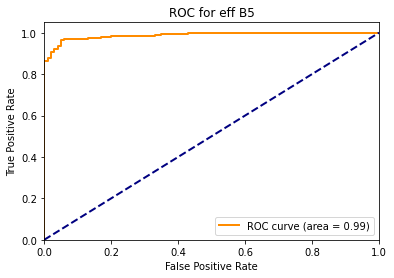

In [36]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for eff B5')
plt.legend(loc="lower right")
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [38]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.97, 0.916058394160584)

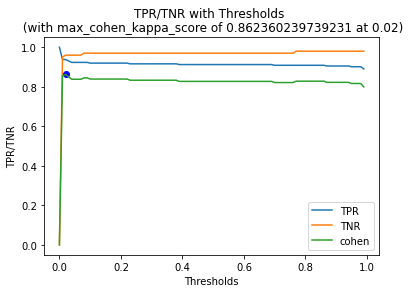

In [39]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='cohen')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [40]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

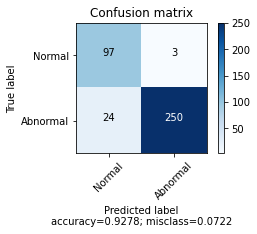

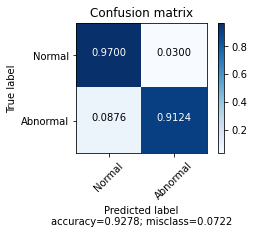

In [44]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0